In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
paths_to_folds_results = {
    "fold_0": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/summary.json",
    "fold_1": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_1/summary.json",    
    "fold_2": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_2/summary.json",
    "fold_3": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_3/summary.json",
    "fold_4": "resources/default-normalization/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/summary.json",
}
labels_mapping = {
    "1": "tumor",
    "2": "adenopathy"
}

In [3]:
new_metrics_per_case = []
for fold, path in paths_to_folds_results.items():
    with open(path, 'r') as file:
        results = json.load(file)
    new_metrics_per_case += [
        {
            "fold": fold.split('_')[-1],
            "prediction_file": item["prediction_file"],
            "reference_file": item["reference_file"],
            "filename": Path(item["reference_file"]).name,
            "class_label": class_,
            "class_name": labels_mapping.get(class_),
            **metrics
        }
        for item in results['metric_per_case']
        for class_, metrics in item["metrics"].items()
    ]

In [4]:
new_metrics_per_case_df = pd.DataFrame(new_metrics_per_case)
display(new_metrics_per_case_df)
new_metrics_per_case_df.to_csv(
    "new_metrics_per_case.csv",
    index=False
)

,fold,prediction_file,reference_file,filename,class_label,class_name,Dice,FN,FP,IoU,TN,TP,n_pred,n_ref
0,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,1,tumor,0.724843,67111,40067,0.568434,75511269,141169,181236,208280
1,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,2,adenopathy,NaN,0,0,NaN,75759616,0,0,0
2,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,1,tumor,0.805310,24600,17781,0.674075,51250191,87652,105433,112252
3,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000020102916421550...,2,adenopathy,NaN,0,0,NaN,51380224,0,0,0
4,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,1,tumor,0.000000,0,1368,0.000000,88865448,0,1368,0
5,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000021011202081810...,2,adenopathy,0.000000,2764,0,0.000000,88864052,0,0,2764
6,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000021052612201586...,1,tumor,0.819066,3758,1355,0.693575,52149970,11573,12928,15331
7,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000021052612201586...,2,adenopathy,NaN,0,0,NaN,52166656,0,0,0
8,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000023011707404892...,1,tumor,0.798077,3602,556,0.664000,45338537,8217,8773,11819
9,0,/media/rrojas/data3/nnUNet/results/trained_mod...,/media/rrojas/data3/nnUNet/data/preprocessed/D...,1.3.12.2.1107.5.1.4.83504.30000023011707404892...,2,adenopathy,0.690100,1980,1476,0.526835,45343608,3848,5324,5828


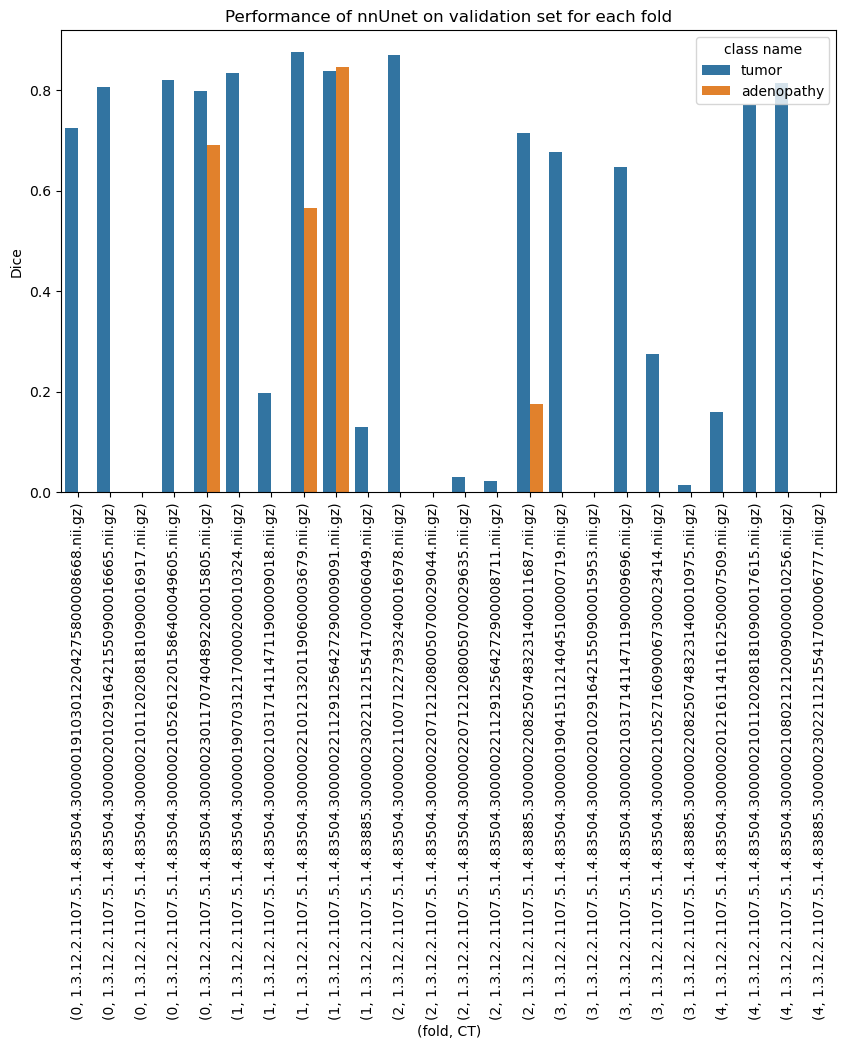

In [23]:
new_df = new_metrics_per_case_df.copy()
new_df['fold_filename'] = new_df.apply(lambda row: f"({row['fold']}, {row['filename']})", axis=1)
plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = sns.barplot(
    data=new_df,
    x='fold_filename',
    y='Dice',
    hue='class_name',
    dodge=True
)
plt.xlabel("(fold, CT)")
plt.legend(title="class name")
plt.xticks(rotation=90, ha="center")
plt.title("Performance of nnUnet on validation set for each fold")
plt.show()

In [27]:
grouped = new_metrics_per_case_df.groupby(["fold", "class_name"])["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,fold,class_name,mean,std
0,0,adenopathy,0.345050,0.487975
1,0,tumor,0.629459,0.353774
2,1,adenopathy,0.352937,0.423465
3,1,tumor,0.574633,0.376650
4,2,adenopathy,0.087963,0.124398
5,2,tumor,0.327204,0.427576
6,3,adenopathy,NaN,NaN
7,3,tumor,0.322421,0.329024
8,4,adenopathy,0.000000,0.000000
9,4,tumor,0.435556,0.416752


In [32]:
grouped = new_metrics_per_case_df.groupby("class_name")["Dice"].agg(["mean", "std"]).reset_index()
display(grouped)

,class_name,mean,std
0,adenopathy,0.227777,0.337407
1,tumor,0.458784,0.369953
